In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
import zipfile
from torch.utils.data import Dataset
local_zip = '/content/drive/My Drive/Colab Notebooks/COCO.zip'

extract_path = '/content/COCO'
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

import torch
import pandas as pd
import os
from torchvision import transforms
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, RandomHorizontalFlip

class COCODataset(Dataset):
    def __init__(self, image_dir, patch_size=4, k_values=(4, 16)):
        self.image_dir = image_dir
        self.image_paths = [os.path.join(image_dir, fname)
                            for fname in os.listdir(image_dir)
                            if fname.endswith('.png') or fname.endswith('.jpg')]
        self.patch_size = patch_size
        self.k_values = k_values

        self.to_tensor = transforms.ToTensor()
        self.resize_128 = transforms.Resize((128, 128))
        self.resize_256 = transforms.Resize((256, 256))
        self.resize_512 = transforms.Resize((512, 512))

    def apply_patch_mask(self, img_tensor, keep_ratio):
        C, H, W = img_tensor.shape
        patch_size = self.patch_size

        # 이미지 패치단위로 분할
        patches = img_tensor.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
        patches = patches.permute(1, 2, 0, 3, 4).reshape(-1, C, patch_size, patch_size) #[(512/k)*(512/k), 3, k, k]

        # 유지할 패치 개수 선택
        num_patches = patches.size(0)
        num_keep = int(num_patches * keep_ratio)
        keep_indices = torch.randperm(num_patches)[:num_keep]

        # 빈 마스크 생성
        mask = torch.zeros_like(patches)

        # 선택된 패치만 마스크에 복사
        mask[keep_indices] = patches[keep_indices]

        # 원래 이미지 형태로 복원
        mask = mask.view(H // patch_size, W // patch_size, C, patch_size, patch_size)
        mask = mask.permute(2, 0, 3, 1, 4).reshape(C, H, W) #[3, 512, 512]

        return mask
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        file_path = self.image_paths[index]
        image = Image.open(file_path).convert('RGB')
        #이미지 크기 줄였다가 늘려서 저화질, 중간화질 이미지 생성
        img_128 = self.to_tensor(self.resize_128(image))
        img_256 = self.to_tensor(self.resize_256(image))
        img_512 = self.to_tensor(image)

        img_128 = self.resize_512(img_128)
        img_256 = self.resize_512(img_256)
        #이미지 비율에 따라 마스킹
        img_256_masked = self.apply_patch_mask(img_256, 1 / self.k_values[0])
        img_512_masked = self.apply_patch_mask(img_512, 1 / self.k_values[1])

        return img_128, img_256_masked, img_512_masked, img_512


import matplotlib.pyplot as plt
import random

train_dataset = COCODataset('/content/COCO/Train')
test_dataset = COCODataset('/content/COCO/Test')

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True,num_workers=4,pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False,num_workers=4,pin_memory=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


img_128 shape: torch.Size([8, 3, 512, 512])
masked_256 shape: torch.Size([8, 3, 512, 512])
masked_512 shape: torch.Size([8, 3, 512, 512])
target shape: torch.Size([8, 3, 512, 512])


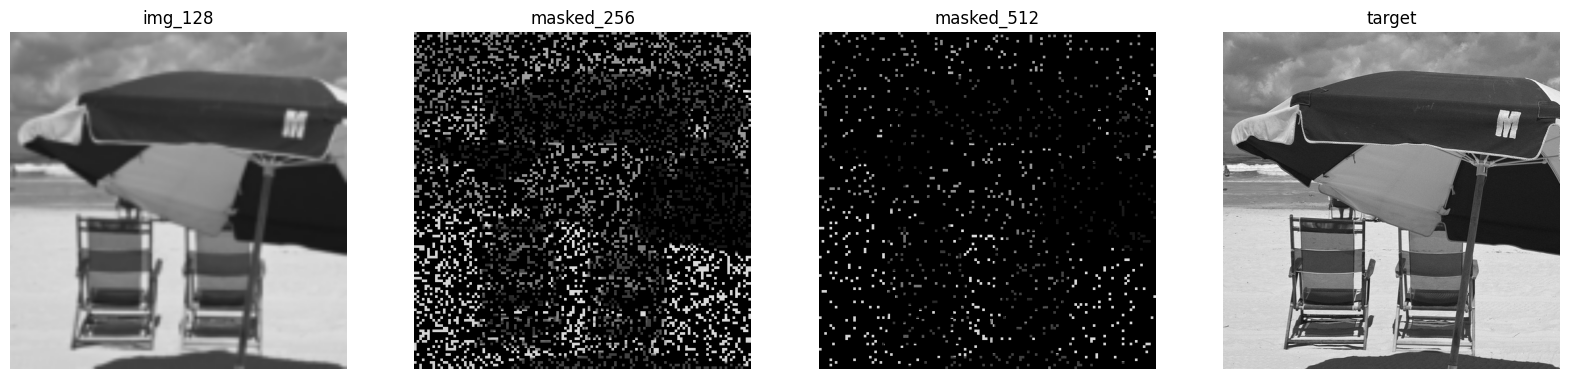

In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms

img_128, masked_256, masked_512, target = next(iter(train_loader))
print("img_128 shape:", img_128.shape)
print("masked_256 shape:", masked_256.shape)
print("masked_512 shape:", masked_512.shape)
print("target shape:", target.shape)

# 첫 번째 데이터만 시각화
sample_img_128 = img_128[0]
sample_masked_256 = masked_256[0]
sample_masked_512 = masked_512[0]
sample_target = target[0]

to_pil = transforms.ToPILImage()

# 옆으로 이미지 출력
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
titles = ["img_128", "masked_256", "masked_512", "target"]
samples = [sample_img_128, sample_masked_256, sample_masked_512, sample_target]

for ax, img, title in zip(axes, samples, titles):
    ax.imshow(to_pil(img))
    ax.set_title(title)
    ax.axis('off')

plt.show()

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import zipfile
import matplotlib.pyplot as plt
import numpy as np

class SuperResolutionDataset(Dataset):
    def __init__(self, base_dataset: Dataset, patch_size=160, stride=80):
        self.base_dataset = base_dataset
        self.patch_size = patch_size
        self.stride = stride
        self.num_images = len(base_dataset)

        # 512 x 512 기준으로 패치 수 고정 계산
        self.patches_per_row = (512 - patch_size) // stride + 1
        self.patches_per_col = (512 - patch_size) // stride + 1
        self.patches_area = self.patches_per_row * self.patches_per_col
        self.total_patches = self.num_images * self.patches_area

    def __len__(self):
        return self.total_patches

    def __getitem__(self, idx):
        # 각 패치 좌측 상단 위치 구한 후 이미지 자르기
        img_idx = idx // self.patches_area # 어떤 이미지의 패치인지
        local_idx = idx % self.patches_area #이미지의 몇 번째 패치인지

        row = local_idx // self.patches_per_row
        col = local_idx % self.patches_per_row
        top = row * self.stride
        left = col * self.stride

        img_128_full, masked_256_full, masked_512_full, target_full = self.base_dataset[img_idx]

        img_128 = img_128_full[:, top:top+self.patch_size, left:left+self.patch_size]
        masked_256 = masked_256_full[:, top:top+self.patch_size, left:left+self.patch_size]
        masked_512 = masked_512_full[:, top:top+self.patch_size, left:left+self.patch_size]
        target = target_full[:, top:top+self.patch_size, left:left+self.patch_size]

        return img_128, masked_256, masked_512, target


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dataset = SuperResolutionDataset(COCODataset('/content/COCO/Train'), patch_size=256, stride=128)
test_dataset = SuperResolutionDataset(COCODataset('/content/COCO/Test'), patch_size=256, stride=128)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,num_workers=4,pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,num_workers=4,pin_memory=True)


img_128 shape: torch.Size([32, 3, 256, 256])
masked_256 shape: torch.Size([32, 3, 256, 256])
masked_512 shape: torch.Size([32, 3, 256, 256])
target shape: torch.Size([32, 3, 256, 256])


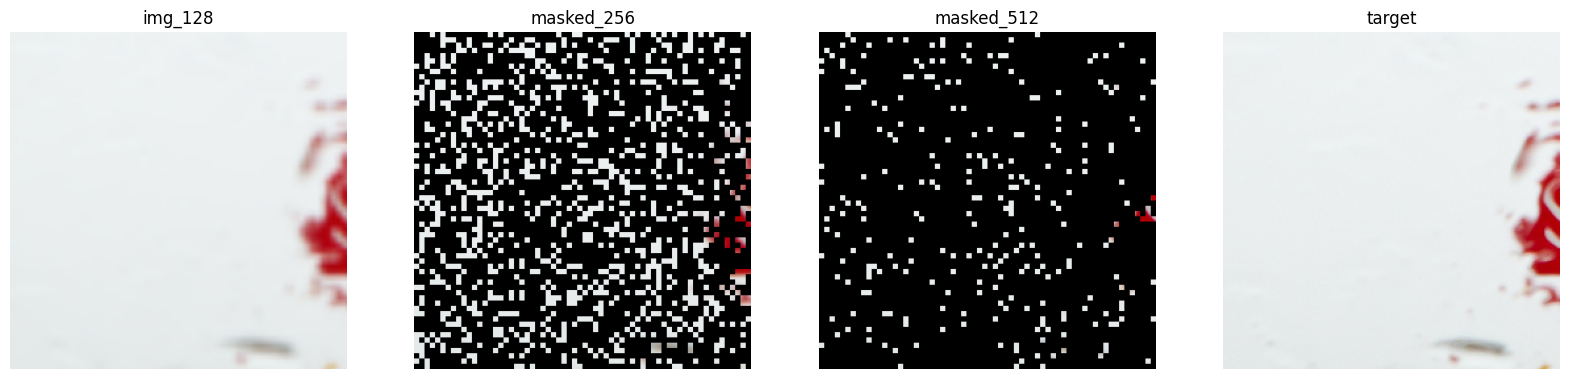

In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms

img_128, masked_256, masked_512, target = next(iter(train_loader))
print("img_128 shape:", img_128.shape)
print("masked_256 shape:", masked_256.shape)
print("masked_512 shape:", masked_512.shape)
print("target shape:", target.shape)

# 첫 번째 데이터만 시각화
sample_img_128 = img_128[0]
sample_masked_256 = masked_256[0]
sample_masked_512 = masked_512[0]
sample_target = target[0]

to_pil = transforms.ToPILImage()

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
titles = ["img_128", "masked_256", "masked_512", "target"]
samples = [sample_img_128, sample_masked_256, sample_masked_512, sample_target]

for ax, img, title in zip(axes, samples, titles):
    ax.imshow(to_pil(img))
    ax.set_title(title)
    ax.axis('off')

plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return x + self.block(x)

class ResSRCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_128 = self._encoder(4)
        self.enc_256 = self._encoder(4)
        self.enc_512 = self._encoder(4)

        self.fusion = nn.Sequential(
            nn.Conv2d(64*3, 64, 3, padding=1),
            nn.ReLU(),
            ResidualBlock(64),
            ResidualBlock(64),
            nn.Conv2d(64, 3, 3, padding=1)
        )

    def _encoder(self, in_c):
        return nn.Sequential(
            nn.Conv2d(in_c, 64, 3, padding=1),
            nn.ReLU(),
            ResidualBlock(64),
            ResidualBlock(64)
        )

    def forward(self, img_128, img_256, img_512):
        # 마스크 생성 및 concat
        mask_128 = torch.ones_like(img_128[:, :1, :, :]).float()
        mask_256 = (img_256.sum(dim=1, keepdim=True) != 0).float()
        mask_512 = (img_512.sum(dim=1, keepdim=True) != 0).float()

        f128 = self.enc_128(torch.cat([img_128, mask_128], dim=1))

        f256 = self.enc_256(torch.cat([img_256, mask_256], dim=1))

        f512 = self.enc_512(torch.cat([img_512, mask_512], dim=1))

        x = torch.cat([f128, f256, f512], dim=1)
        return torch.clamp(self.fusion(x), min=0.0, max=1.0)

Ressrcnn = ResSRCNN().cuda()
#파라미터 정보 출력
def params_num(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name:40s}: {param.numel():,}")
    print(f"Total Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

params_num(Ressrcnn)

enc_128.0.weight                        : 2,304
enc_128.0.bias                          : 64
enc_128.2.block.0.weight                : 36,864
enc_128.2.block.0.bias                  : 64
enc_128.2.block.2.weight                : 36,864
enc_128.2.block.2.bias                  : 64
enc_128.3.block.0.weight                : 36,864
enc_128.3.block.0.bias                  : 64
enc_128.3.block.2.weight                : 36,864
enc_128.3.block.2.bias                  : 64
enc_256.0.weight                        : 2,304
enc_256.0.bias                          : 64
enc_256.2.block.0.weight                : 36,864
enc_256.2.block.0.bias                  : 64
enc_256.2.block.2.weight                : 36,864
enc_256.2.block.2.bias                  : 64
enc_256.3.block.0.weight                : 36,864
enc_256.3.block.0.bias                  : 64
enc_256.3.block.2.weight                : 36,864
enc_256.3.block.2.bias                  : 64
enc_512.0.weight                        : 2,304
enc_512.0.bias

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 하이퍼파라미터
epoch = 1
lr = 0.01
weight_decay = 1e-3
total_batches = len(train_loader)
# 디바이스 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
Ressrcnn = ResSRCNN().to(device)

# 옵티마이저 및 손실 함수
optimizer = torch.optim.Adam(Ressrcnn.parameters(), lr=0.001, weight_decay=1e-4) #Adam 사용

criterion = nn.MSELoss()

# PSNR 계산 함수
def calculate_psnr(output, target, max_pixel=1.0):
    mse = torch.mean((output - target) ** 2)
    if mse == 0:
        return float('inf')
    psnr = 20 * torch.log10(torch.tensor(max_pixel)) - 10 * torch.log10(mse)
    return psnr.item()


# 학습 함수
def train(model, optimizer, train_loader, epoch):
    model.train()
    train_loss = []
    train_psnr = []

    for i, (img_128, img_256, img_512, target) in enumerate(train_loader):
        img_128 = img_128.to(device)
        img_256 = img_256.to(device)
        img_512 = img_512.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(img_128, img_256, img_512)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        psnr = calculate_psnr(output, target)
        train_psnr.append(psnr)
        train_loss.append(loss.item())

        print(f'\rEpoch {epoch} [{i+1}/{len(train_loader)}] - Loss: {loss.item():.4f} / PSNR: {psnr:.2f}', end='')

    avg_loss = sum(train_loss) / len(train_loss)
    avg_psnr = sum(train_psnr) / len(train_psnr)
    print(f'\nepoch {epoch}) train loss: {avg_loss:.4f} / train PSNR: {avg_psnr:.2f} dB')

    return train_loss


# 테스트 함수
def test(model, test_loader, epoch):
    model.eval()
    test_loss = []
    test_psnr = []

    with torch.no_grad():
        for i, (img_128, img_256, img_512, target) in enumerate(test_loader):
            img_128 = img_128.to(device)
            img_256 = img_256.to(device)
            img_512 = img_512.to(device)
            target = target.to(device)

            output = model(img_128, img_256, img_512)
            loss = criterion(output, target)

            psnr = calculate_psnr(output, target)
            test_psnr.append(psnr)
            test_loss.append(loss.item())
            # 진행률 출력
            print(f'\rEpoch {epoch} [{i+1}/{len(train_loader)}] - Loss: {loss.item():.4f} / PSNR: {psnr:.2f}', end='')

    avg_loss = sum(test_loss) / len(test_loss)
    avg_psnr = sum(test_psnr) / len(test_psnr)
    print(f'epoch {epoch}) test loss: {avg_loss:.4f} / test PSNR: {avg_psnr:.2f} dB')


all_train_losses = []

for i in range(epoch):
    batch_losses = train(Ressrcnn, optimizer, train_loader, i)
    all_train_losses.extend(batch_losses)  # batch별 loss 누적 저장
    test(Ressrcnn, test_loader, i)

# 1 에포크 동안의 batch별 loss 곡선 그리기
plt.figure(figsize=(8,5))
plt.plot(all_train_losses, label='Train Loss')
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.title('Train Loss Curve for 1 Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# 모델의 가중치 저장
def save_weights_to_csv(model, filename='weights.csv'):
    weights = {}
    for name, param in model.state_dict().items():
        weights[name] = param.cpu().detach().numpy().flatten()

    df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in weights.items()]))
    df.to_csv(filename, index=False)
    print(f"Weights saved to {filename}")

#필요 시 주석해제
#save_weights_to_csv(Ressrcnn, 'random_mask_k4.csv')

Weights saved to random_mask_2epk.csv


In [ ]:
# 모델의 가중치 불러오기
import os
import pandas as pd
import torch

def load_weights_from_csv(model, filename='weights.csv'):
    # Google Drive 경로 설정(필요 시 변경)
    drive_path = '/content/drive/MyDrive/Colab Notebooks/'
    full_path = os.path.join(drive_path, filename)

    # CSV 파일 읽기
    df = pd.read_csv(full_path)
    state_dict = model.state_dict()

    for name, param in state_dict.items():
        if name in df.columns:
            weight_data = df[name].dropna().values
            state_dict[name] = torch.tensor(weight_data, dtype=param.dtype).view_as(param)

    # 모델에 로드
    model.load_state_dict(state_dict)
    print(f"Weights loaded from {full_path}")

#필요 시 주석해제
#load_weights_from_csv(Ressrcnn, 'random_mask_k4.csv')


Weights loaded from /content/drive/MyDrive/Colab Notebooks/random_mask_2epk.csv


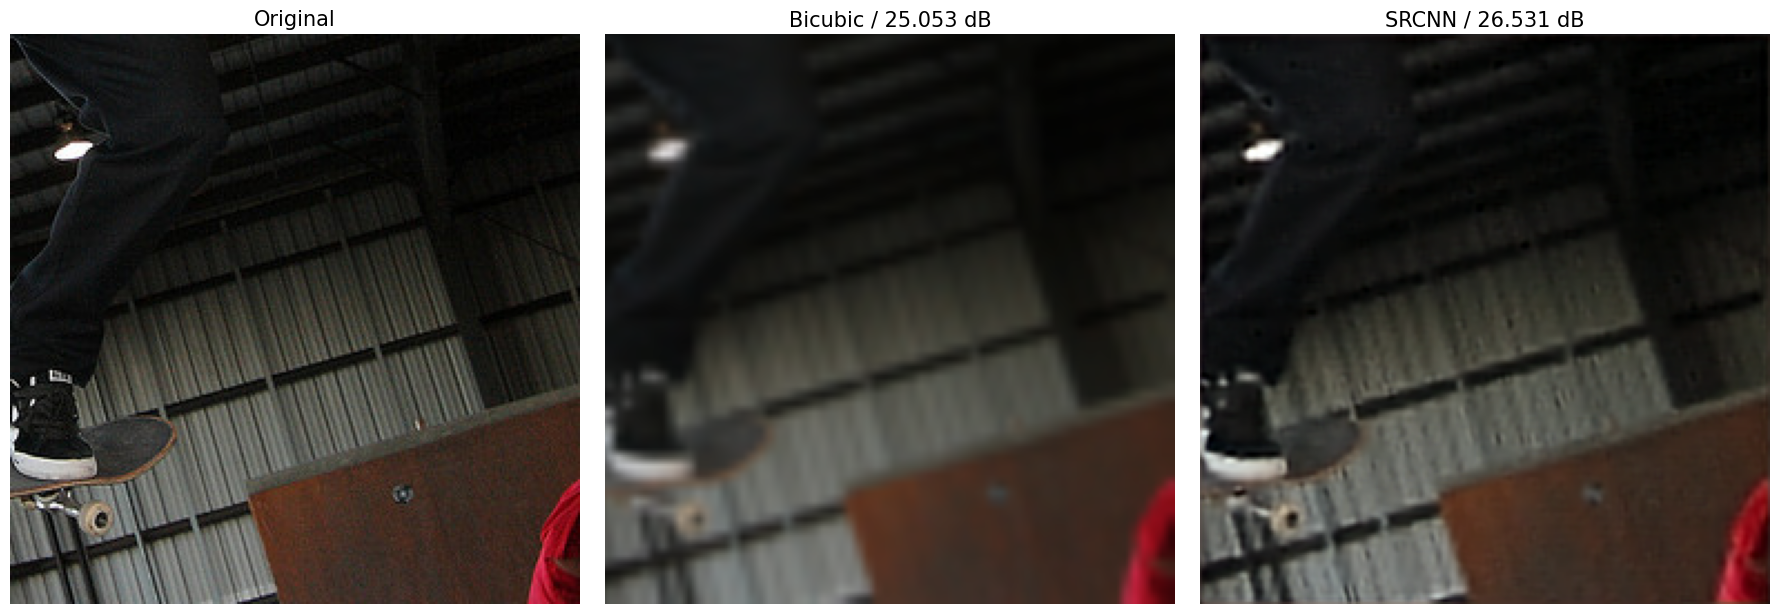

In [ ]:
import torch
import matplotlib.pyplot as plt
import random
from torchvision.transforms import ToPILImage

to_pil_image = ToPILImage()

# 랜덤 인덱스 하나 뽑기
random_idx = random.randint(0, len(test_loader.dataset) - 1)

# 데이터셋에서 랜덤 이미지 가져오기
img_128, img_256, img_512, target = test_loader.dataset[random_idx]

# 배치 차원 추가 및 device 이동
img_128 = img_128.unsqueeze(0).to(device)
img_256 = img_256.unsqueeze(0).to(device)
img_512 = img_512.unsqueeze(0).to(device)
target = target.unsqueeze(0).to(device)

# 모델 예측
Ressrcnn.eval()
with torch.no_grad():
    output = Ressrcnn(img_128, img_256, img_512)

# PSNR 계산
psnr_bicubic = calculate_psnr(img_128[0], target[0])  # GPU 계산
psnr_srcnn = calculate_psnr(output[0], target[0])  # GPU 계산

# 이미지 CPU 이동 및 numpy 변환 (시각화용)
hr = target[0].cpu().permute(1, 2, 0).numpy()
lr_up = img_128[0].cpu().permute(1, 2, 0).numpy()

# 시각화
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(hr)
plt.title("Original", fontsize=15)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(lr_up)
plt.title(f"Bicubic / {psnr_bicubic:.3f} dB", fontsize=15)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(to_pil_image(output[0].cpu()))
plt.title(f"SRCNN / {psnr_srcnn:.3f} dB", fontsize=15)
plt.axis("off")

plt.tight_layout()
plt.show()



In [ ]:
total_psnr_bicubic = 0.0
total_psnr_srcnn = 0.0
num_samples = 0

Ressrcnn.eval()
#모든 테스트 셋 평균 PSNR, 저화질 이미지 PSNR
with torch.no_grad():
    for img_128, img_256, img_512, target in test_loader:
        img_128 = img_128.to(device)
        img_256 = img_256.to(device)
        img_512 = img_512.to(device)
        target = target.to(device)

        output = Ressrcnn(img_128, img_256, img_512)

        # 배치 안의 각 샘플별로 PSNR 계산
        batch_size = img_128.size(0)
        for i in range(batch_size):
            psnr_bicubic = calculate_psnr(img_128[i], target[i])
            psnr_srcnn = calculate_psnr(output[i], target[i])

            total_psnr_bicubic += psnr_bicubic
            total_psnr_srcnn += psnr_srcnn
            num_samples += 1

avg_psnr_bicubic = total_psnr_bicubic / num_samples
avg_psnr_srcnn = total_psnr_srcnn / num_samples

print(f"[평균 PSNR] Bicubic: {avg_psnr_bicubic:.3f} dB")
print(f"[평균 PSNR] SRCNN:   {avg_psnr_srcnn:.3f} dB")


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class MaskDataset(Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.image_paths = [os.path.join(image_dir, fname)
                            for fname in os.listdir(image_dir)
                            if fname.endswith('.png') or fname.endswith('.jpg')]
        self.resize_128 = transforms.Resize((128, 128))
        self.resize_256 = transforms.Resize((256, 256))
        self.resize_512 = transforms.Resize((512, 512))
        self.to_tensor = transforms.ToTensor()
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        file_path = self.image_paths[index]
        image = Image.open(file_path).convert('RGB')

        img_128 = self.to_tensor(self.resize_128(image))
        img_256 = self.to_tensor(self.resize_256(image))
        img_512 = self.to_tensor(image)

        img_128 = self.resize_512(img_128)
        img_256 = self.resize_512(img_256)

        return img_128, img_256, img_512 #마스킹 안 된 데이터를 출력


import matplotlib.pyplot as plt
import random

train_dataset = MaskDataset('/content/COCO/Train')
test_dataset = MaskDataset('/content/COCO/Test')

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True,num_workers=4,pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False,num_workers=4,pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
import torch
import torch.nn as nn

class MaskNet(nn.Module):
    def __init__(self):
        super(MaskNet, self).__init__()

        # 인코더: Down-sampling
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2),  # Down 512→256
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2),  # Down 256→128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )

        # 디코더: Up-sampling
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # Up 128→256
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # Up 256→512
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )

        # 출력 레이어: 중요도 맵
        self.dec3 = nn.Sequential(
            nn.Conv2d(32, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.enc1(x)    # [B, 32, 512, 512]
        x = self.enc2(x)    # [B, 64, 256, 256]
        x = self.enc3(x)    # [B, 128, 128, 128]
        x = self.dec1(x)    # [B, 64, 256, 256]
        x = self.dec2(x)    # [B, 32, 512, 512]
        score_map = self.dec3(x)  # [B, 1, 512, 512]
        return score_map

def masking(patch_size, score_map, img_mid, img_high):
    B, C, H, W = img_high.shape
    k = patch_size
    H_k, W_k = H // k, W // k  # 패치 수

    num_patches = H_k * W_k
    num_high = num_patches // 16
    num_mid = num_patches // 4


    patches = score_map.unfold(2, k, k).unfold(3, k, k)  # (B,1,H//k,W//k,k,k)
    patch_scores = patches.mean(dim=[-1, -2])  # (B,1,H//k,W//k)
    # 중요도 기준 내림차순 정렬
    scores = patch_scores.view(B, -1)  # (B, num_patches)
    sorted_vals, sorted_idx = torch.sort(scores, dim=1, descending=True)
    top_idx = sorted_idx[:, :num_high]         # 고해상도에서 사용할 패치
    mid_idx = sorted_idx[:, num_high:num_high+num_mid]  # 중해상도에서 사용할 패치
    # 마스크 초기화
    high_mask = torch.zeros((B, H_k * W_k), device=img_high.device)
    mid_mask = torch.zeros((B, H_k * W_k), device=img_mid.device)

    #학습 가능하게 함
    high_mask = high_mask.detach()
    mid_mask = mid_mask.detach()

    # 인덱스별로 마스크 설정
    batch_idx = torch.arange(B).unsqueeze(1).to(img_high.device)
    high_mask[batch_idx, top_idx] = 1
    mid_mask[batch_idx, mid_idx] = 1

    # reshape to (B, 1, H_k, W_k)
    high_mask = high_mask.view(B, 1, H_k, W_k)
    mid_mask = mid_mask.view(B, 1, H_k, W_k)

    # 패치 마스크를 원래 해상도로 보간 없이 업샘플링
    high_mask_upsampled = high_mask.repeat_interleave(k, dim=2).repeat_interleave(k, dim=3)  # (B,1,H,W)
    mid_mask_upsampled  = mid_mask.repeat_interleave(k, dim=2).repeat_interleave(k, dim=3)   # (B,1,H,W)

    # 고화질에서 마스킹
    masked_high = img_high * high_mask_upsampled

    # 중간화질에서 마스킹
    masked_mid = img_mid * mid_mask_upsampled

    return masked_mid, masked_high

mask_net = MaskNet().to(device)
params_num(mask_net)

import matplotlib.pyplot as plt
import random

train_dataset = MaskDataset('/content/COCO/Train')
test_dataset = MaskDataset('/content/COCO/Test')

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True,num_workers=4,pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False,num_workers=4,pin_memory=True)


enc1.0.weight                           : 864
enc1.0.bias                             : 32
enc1.1.weight                           : 32
enc1.1.bias                             : 32
enc2.0.weight                           : 18,432
enc2.0.bias                             : 64
enc2.1.weight                           : 64
enc2.1.bias                             : 64
enc3.0.weight                           : 73,728
enc3.0.bias                             : 128
enc3.1.weight                           : 128
enc3.1.bias                             : 128
dec1.0.weight                           : 32,768
dec1.0.bias                             : 64
dec1.1.weight                           : 64
dec1.1.bias                             : 64
dec2.0.weight                           : 8,192
dec2.0.bias                             : 32
dec2.1.weight                           : 32
dec2.1.bias                             : 32
dec3.0.weight                           : 32
dec3.0.bias                         

In [ ]:
import os
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import torch
import torch.nn as nn

# 하이퍼파라미터
epochs = 3
lr = 0.001
weight_decay = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 모델, 손실, 옵티마이저
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(mask_net.parameters(), lr=lr, weight_decay=weight_decay)
mask_regulation = 0.01  # 마스크 규제
for param in Ressrcnn.parameters():
    param.requires_grad = False

def train_masknet(model1, model2, loader, optimizer, criterion, epoch,patch_size=4):
    model2.train()
    total_loss = 0.0
    batch_losses = []
    for i, (img_128, img_256, img_512) in enumerate(loader):
        img_128, img_256, img_512 = img_128.to(device), img_256.to(device), img_512.to(device)

        optimizer.zero_grad()

        # 1. 마스크넷으로부터 마스크 생성
        score_map = model2(img_512)  # (B,1,H/k,W/k)
        masked_256, masked_512 = masking(4, score_map, img_256, img_512)

        # 2. Ressrcnn으로 복원
        recon = model1(img_128, masked_256, masked_512)

        # 3. 주요 손실
        loss_recon = criterion(recon, img_512)

        # 4. 마스크 sparsity 유도 (덜 남기도록)
        loss_mask_sparsity = score_map.mean()

        # 5. 중요한 부분 보존 유도 (잘못 제거한 부분 패널티)
        mask_removed = ((masked_256 == 0) & (masked_512 == 0)).float().detach()
        #마스크가 제거된 영역에 오차를 곱해 잘못 제거시 loss커짐
        loss_mask_importance = torch.mean(((recon - img_512) ** 2 * mask_removed))

        # 6. 전체 손실 합산
        loss = loss_recon + 0.01 * loss_mask_sparsity + loss_mask_importance

        # 7. 역전파
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()

        batch_losses.append(loss.item())
        total_loss += loss.item()
        print(f'\rEpoch {epoch} [{i+1}/{len(loader)}] - Loss: {loss.item():.4f}', end='')

    avg_loss = total_loss / len(loader)
    print(f'\n[MaskNet] Epoch {epoch} Average Loss: {avg_loss:.4f}')

    return batch_losses


all_train_losses = []

for epoch in range(epochs):
    batch_losses = train_masknet(Ressrcnn, mask_net, train_loader, optimizer, criterion, epoch, patch_size=4)
    all_train_losses.extend(batch_losses)

# 1 에포크 동안의 loss 곡선 그리기 (epochs가 1일 경우)
plt.figure(figsize=(8,5))
plt.plot(all_train_losses, label='Train Loss')
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.title('Train Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#가중치 저장(필요 시 주석 풀기)
#save_weights_to_csv(mask_net, 'maskweights_k4.csv')

Weights saved to maskweights_k4.csv


In [ ]:
#가중치 불러오기(필요 시 주석 풀기)
#load_weights_from_csv(mask_net, 'maskweights_k4.csv')

Weights loaded from /content/drive/MyDrive/Colab Notebooks/maskweights_k4.csv


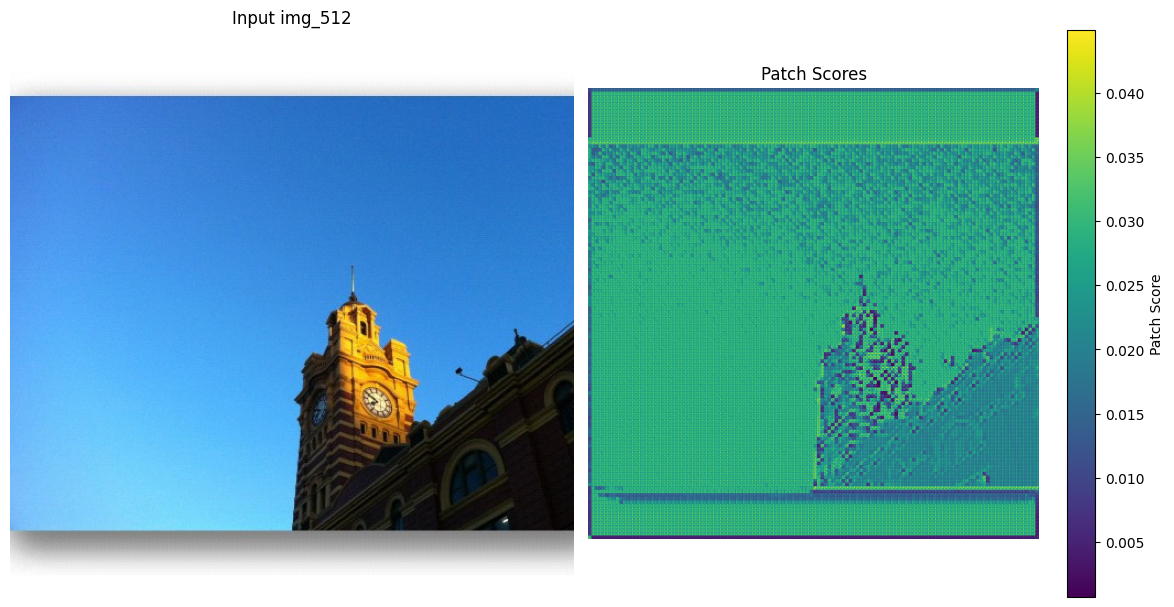

In [ ]:
random_idx = random.randint(0, len(test_loader.dataset) - 1)

# 테스트 데이터셋에서 이미지 가져오기
img_128, img_256, img_512 = test_loader.dataset[random_idx]

# 배치 차원 추가 및 device 이동
img_128 = img_128.unsqueeze(0).to(device)
img_256 = img_256.unsqueeze(0).to(device)
img_512 = img_512.unsqueeze(0).to(device)

mask_net.eval()
with torch.no_grad():
    mask_score = mask_net(img_512)  # (B, 1, H, W)
    patch_size = 4

img_np = np.transpose(img_512.squeeze().cpu().numpy(), (1, 2, 0))
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Input img_512')
plt.imshow(img_np)
plt.axis('off')

# Patch Score 표시
plt.subplot(1, 2, 2)
plt.title('Patch Scores')
plt.imshow(mask_score.squeeze().cpu().numpy(), cmap='viridis')
plt.colorbar(label='Patch Score')
plt.axis('off')

plt.tight_layout()
plt.show()

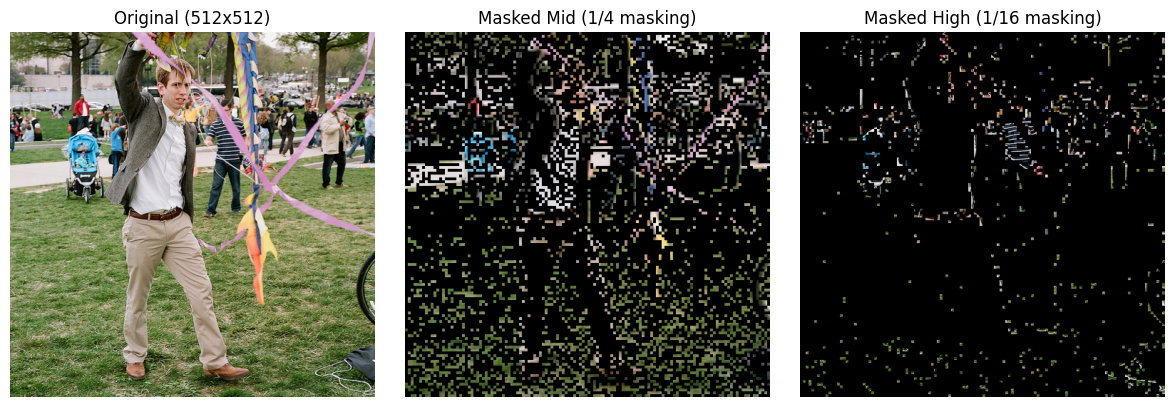

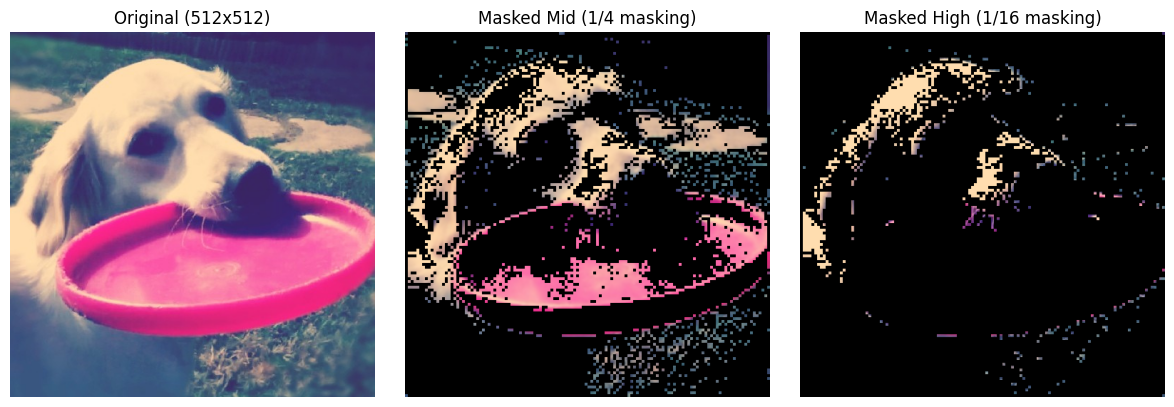

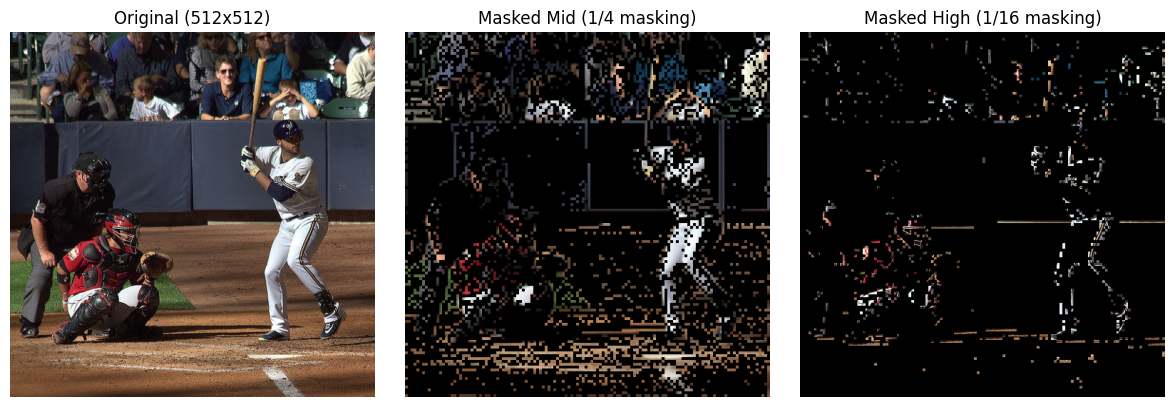

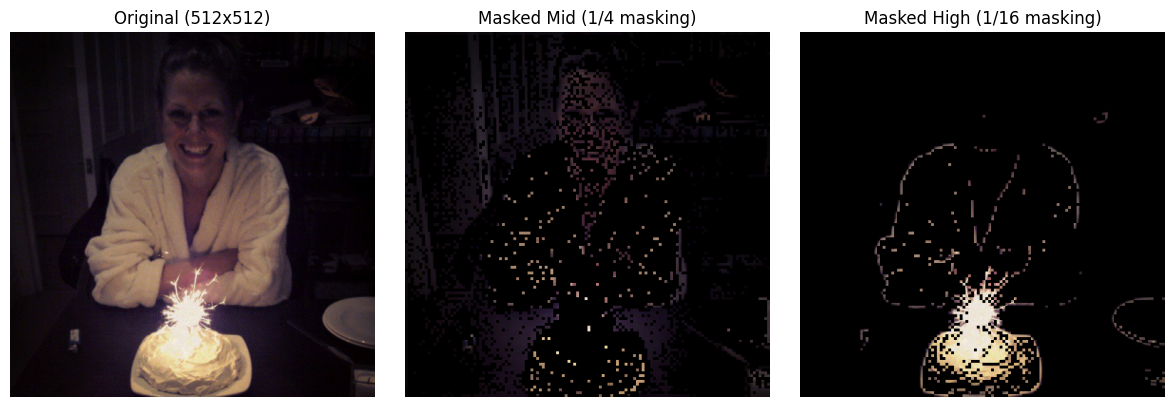

In [ ]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def test_and_plot(model, dataloader, device, patch_size=4):
    model.eval()
    with torch.no_grad():
        for _, img_256, img_512 in dataloader:
            img_256 = img_256.to(device)  # (B, 3, 512, 512) assumed
            img_512 = img_512.to(device)

            patch_scores = model(img_512)

            # 마스킹 수행
            masked_256, masked_512 = masking(patch_size, patch_scores, img_256, img_512)

            visualize_results(img_512, masked_256, masked_512)
            break  # 한 배치만 테스트

def visualize_results(img_512, masked_256, masked_512):

    img_512 = img_512.cpu()
    masked_256 = masked_256.cpu()
    masked_512 = masked_512.cpu()

    B = img_512.shape[0]
    for i in range(min(B, 4)):  # 최대 4개까지 출력
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(TF.to_pil_image(img_512[i]))
        axs[0].set_title("Original (512x512)")

        axs[1].imshow(TF.to_pil_image(masked_256[i]))
        axs[1].set_title("Masked Mid (1/4 masking)")

        axs[2].imshow(TF.to_pil_image(masked_512[i]))
        axs[2].set_title("Masked High (1/16 masking)")

        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True,num_workers=4,pin_memory=True)
test_and_plot(mask_net, test_loader, device=device, patch_size=4)

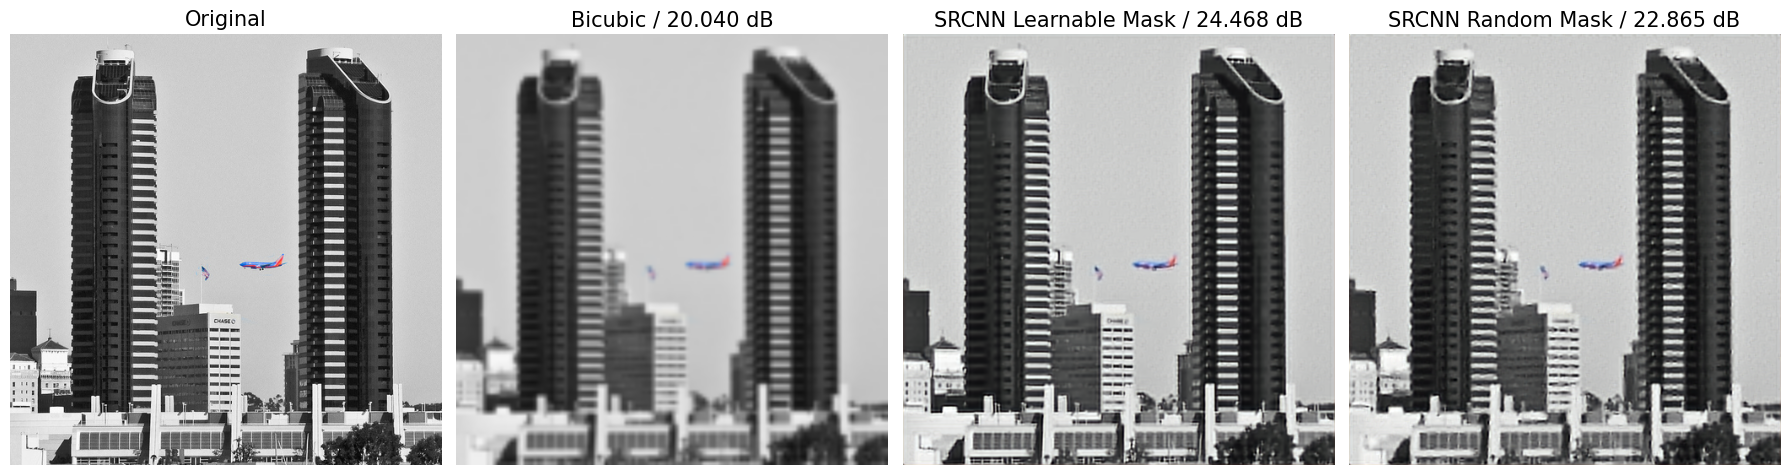

In [ ]:
import torch
import matplotlib.pyplot as plt
import random
from torchvision.transforms import ToPILImage

to_pil_image = ToPILImage()

def apply_patch_mask(img_tensor, keep_ratio):
    # img_tensor: (B, C, H, W)
    B, C, H, W = img_tensor.shape
    patch_size = 4

    # unfold -> (B, C, H_patches, W_patches, patch_size, patch_size)
    patches = img_tensor.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    H_patches = patches.size(2)
    W_patches = patches.size(3)

    # (B, C, H_patches, W_patches, pH, pW) -> (B, H_patches, W_patches, C, patch_size, patch_size)
    patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous()

    # Flatten patches: (B, N, C, patch_size, patch_size)
    patches = patches.view(B, -1, C, patch_size, patch_size)
    num_patches = patches.size(1)
    num_keep = int(num_patches * keep_ratio)

    # Keep 랜덤 인덱스 선택
    keep_indices = torch.randperm(num_patches)[:num_keep]

    # 마스킹 (zeros)
    mask = torch.zeros_like(patches)
    mask[:, keep_indices] = patches[:, keep_indices]

    # 복원: (B, H_patches, W_patches, C, patch_size, patch_size)
    mask = mask.view(B, H_patches, W_patches, C, patch_size, patch_size)

    # (B, C, H_patches, patch_size, W_patches, patch_size) -> (B, C, H, W)
    mask = mask.permute(0, 3, 1, 4, 2, 5).contiguous().view(B, C, H, W)

    return mask



# 랜덤 인덱스 하나 뽑기
random_idx = random.randint(0, len(test_loader.dataset) - 1)

# 데이터셋에서 랜덤 이미지 가져오기
img_128, img_256, img_512 = test_loader.dataset[random_idx]

# 배치 차원 추가 및 device 이동
img_128 = img_128.unsqueeze(0).to(device)
img_256 = img_256.unsqueeze(0).to(device)
img_512 = img_512.unsqueeze(0).to(device)

mask_net.eval()
with torch.no_grad():
    patch_scores  = mask_net(img_512)
    masked_256, masked_512 = masking(patch_size, patch_scores, img_256, img_512)

# 모델 예측
Ressrcnn.eval()
with torch.no_grad():
    output = Ressrcnn(img_128, masked_256, masked_512)

# PSNR 계산 (배치 첫번째 샘플 기준)
psnr_bicubic = calculate_psnr(img_128[0], img_512[0])  # GPU 계산
psnr_srcnn = calculate_psnr(output[0], img_512[0])  # GPU 계산

# 랜덤 마스크도 같이 적용 (배치 차원 유지)
random_256 = apply_patch_mask(img_256, 1/4)
random_512 = apply_patch_mask(img_512, 1/16)

Ressrcnn.eval()
with torch.no_grad():
    output_random = Ressrcnn(img_128, random_256, random_512)

psnr_srcnn_random = calculate_psnr(output_random[0], img_512[0])  # GPU 계산

# 이미지 CPU 이동 및 numpy 변환 (시각화용)
hr = img_512[0].cpu().permute(1, 2, 0).numpy()
lr_up = img_128[0].cpu().permute(1, 2, 0).numpy()

plt.figure(figsize=(18, 6))

plt.subplot(1, 4, 1)
plt.imshow(hr)
plt.title("Original", fontsize=15)
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(lr_up)
plt.title(f"Bicubic / {psnr_bicubic:.3f} dB", fontsize=15)
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(to_pil_image(output[0].cpu()))
plt.title(f"SRCNN Learnable Mask / {psnr_srcnn:.3f} dB", fontsize=15)
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(to_pil_image(output_random[0].cpu()))
plt.title(f"SRCNN Random Mask / {psnr_srcnn_random:.3f} dB", fontsize=15)
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
total_psnr_bicubic = 0.0
total_psnr_srcnn_learnable = 0.0
total_psnr_srcnn_random = 0.0
num_samples = 0

Ressrcnn.eval()
mask_net.eval()

with torch.no_grad():
    for img_128, img_256, img_512 in test_loader:
        img_128 = img_128.to(device)
        img_256 = img_256.to(device)
        img_512 = img_512.to(device)

        batch_size = img_128.size(0)

        # [1] Bicubic PSNR (배치별로 한 장씩 계산)
        for i in range(batch_size):
            psnr_bicubic = calculate_psnr(img_128[i], img_512[i])
            total_psnr_bicubic += psnr_bicubic

        # [2] Learnable Mask 적용
        patch_scores = mask_net(img_512)
        masked_256, masked_512 = masking(patch_size, patch_scores, img_256, img_512)
        output_learnable = Ressrcnn(img_128, masked_256, masked_512)
        for i in range(batch_size):
            psnr_srcnn_learnable = calculate_psnr(output_learnable[i], img_512[i])
            total_psnr_srcnn_learnable += psnr_srcnn_learnable

        # [3] Random Mask 적용
        random_256 = apply_patch_mask(img_256, 1/4)
        random_512 = apply_patch_mask(img_512, 1/16)
        output_random = Ressrcnn(img_128, random_256, random_512)
        for i in range(batch_size):
            psnr_srcnn_random = calculate_psnr(output_random[i], img_512[i])
            total_psnr_srcnn_random += psnr_srcnn_random

        num_samples += batch_size

# 평균 PSNR 계산
avg_psnr_bicubic = total_psnr_bicubic / num_samples
avg_psnr_srcnn_learnable = total_psnr_srcnn_learnable / num_samples
avg_psnr_srcnn_random = total_psnr_srcnn_random / num_samples

print(f"[평균 PSNR] Bicubic               : {avg_psnr_bicubic:.3f} dB")
print(f"[평균 PSNR] SRCNN + Learnable Mask: {avg_psnr_srcnn_learnable:.3f} dB")
print(f"[평균 PSNR] SRCNN + Random Mask   : {avg_psnr_srcnn_random:.3f} dB")



[평균 PSNR] Bicubic               : 23.714 dB
[평균 PSNR] SRCNN + Learnable Mask: 26.965 dB
[평균 PSNR] SRCNN + Random Mask   : 25.855 dB
